## Περιεχόμενα

- Ανάλυση του dataset, φύσης δεδομένων και της μεταβλητής στόχου
- Ανάλυση των αριθμητικών και κατηγορικών κατανομών
- Κωδικοποίηση των χαρακτηριστικών βάσει των συμπερασμάτων
- Δημιουργία pipeline με τα αντίστοιχα transformations και αποθήκευση του preprocessed dataframe 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

### Κλάσεις που θα χρησιμοποιηθούν για το preprocess pipeline στο τέλος του αρχείου Jupyter Lab
- Οι αποφάσεις για αυτές τις ομαδικοποιήσεις λαμβάνονται κατά τη διάρκεια του notebook

In [2]:
class MtransMapper(BaseEstimator, TransformerMixin):
    '''
    Πραγματοποιεί τις ομαδοποιήσεις των σπάνιων κατηγοριών του
    χαρακτηριστικού 'MTRANS'
    '''
    
    def __init__(self, variables):
        self.mapping = {'Bike': 'Walking',
                        'Motorbike': 'Automobile'}
        self.variables = variables # MTRANS

    def fit(self, X, y=None):
        return self

    def transform(self, X):        
        X[self.variables] = X[self.variables].replace(self.mapping)
        
        return X
    
class RoundTransformer(BaseEstimator, TransformerMixin):
    '''
    Στρογγυλοποιεί στον πλησιέστερο ακέραιο τα συνθετικά
    δεδομένα ορισμένων κατηγορικών χαρακτηριστικών
    τα οποία εμφανίζονται ως float 
    '''
    
    def __init__(self, variables):
        self.variables = variables # FCVC, NCP, CH2O, FAF, TUE
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):  
        X[self.variables] = X[self.variables].round()
        
        return X
    
    
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    '''
    Κάνει ordinal encoding μέσω mapping 
    σε ορισμένα χαρακτηριστικά
    '''
    
    def __init__(self, variables):
        self.variables = variables # CALC / CAEC / NObeyesdad

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        if self.variables == 'CALC': 
            
            X_new.loc[X_new[self.variables]=="Always", self.variables] = 'Frequently'
            ordinal_map = {"no": 0, 
                           "Sometimes": 1,
                           "Frequently": 2}
            
        elif self.variables == 'CAEC':
            
            ordinal_map = {"no": 0, 
                           "Sometimes": 1,
                           "Frequently": 2,
                           "Always": 4}
            
        elif self.variables == 'NObeyesdad':
            
            ordinal_map = {'Insufficient_Weight': 0,
                           'Normal_Weight': 1,
                           'Overweight_Level_I': 2,
                           'Overweight_Level_II': 3,
                           'Obesity_Type_I': 4,
                           'Obesity_Type_II': 5,
                           'Obesity_Type_III': 6}
            
        X_new[self.variables] = X_new[self.variables].map(ordinal_map)
        return X_new

In [3]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [4]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
print(f"σειρές (δεδομένα): {df.shape[0]}\nστήλες (χαρακτηριστικα + στόχος): {df.shape[1]}\nΣυνολικές απουσιάζουσες τιμές: {df.isnull().sum().sum()}") 

σειρές (δεδομένα): 2111
στήλες (χαρακτηριστικα + στόχος): 17
Συνολικές απουσιάζουσες τιμές: 0


## Χαρακτηριστικά

| Χαρακτηριστικό                      | Περιγραφή                                         | Πιθανές Απαντήσεις                                  | Τύπος των Χαρακτηριστικών*       |
|-------------------------------------|---------------------------------------------------|-----------------------------------------------------|----------------------------------|
| Gender                              | Φύλο                                              | Γυναίκα/Άντρας                                      | Δυαδικό Κατηγορικό (Binary)      |
| Age                                 | Ηλικία                                            | Συνεχής τιμή                                        | Συνεχές Αριθμητικό               |
| Height                              | Ύψος                                              | Συνεχής τιμή                                        | Συνεχές Αριθμητικό               |
| Weight                              | Βάρος                                             | Συνεχής τιμή                                        | Συνεχές Αριθμητικό               |
| family_history_with_overweight      | Οικογενειακό ιστορικό παχυσαρκίας                 | Ναι/Όχι                                             | Δυαδικό Κατηγορικό (Binary)      |
| FAVC                                | Συχνή κατανάλωση τροφίμων υψηλής θερμιδικής αξίας | Ναι/Όχι                                             | Δυαδικό Κατηγορικό (Binary)      |
| FCVC                                | Συχνή κατανάλωση λαχανικών στα γεύματα            | Ποτέ/Μερικές Φορές/Συνέχεια                         | Διατεταγμένο κατηγορικό (Ordinal)|
| NCP                                 | Αριθμός γευμάτων ημερησίως                        | Ένα με Δύο/Τρία/Περισσότερα από τρία                | Διατεταγμένο κατηγορικό (Ordinal)|
| CAEC                                | Φαγητό ενδιάμεσα στα γεύματα                      | Καθόλου/Μερικές Φορές/Συχνά/Συνέχεια                | Διατεταγμένο κατηγορικό (Ordinal)|
| SMOKE                               | Κάπνισμα                                          | Ναι/Όχι                                             | Δυαδικό Κατηγορικό (Binary)      |
| CH2O                                | Πρόσληψη Νερού                                    | <1 Λίτρο/ 1-2 Λίτρα/ >2 Λίτρα                       | Διατεταγμένο κατηγορικό (Ordinal)|
| SCC                                 | Μέτρηση των ημερησίων θερμίδων                    | Ναι/Όχι                                             | Δυαδικό Κατηγορικό (Binary)      |
| FAF                                 | Συχνότητα σωματικής άσκησης                       | Καθόλου/1-2 Μέρες/2-4 Μέρες/4-5 Μέρες               | Διατεταγμένο κατηγορικό (Ordinal)|
| TUE                                 | Χρόνος χρήσης τεχνολογικών συσκευών               | 0-2 Ώρες/3-5 Ώρες/>5 Ώρες                           | Διατεταγμένο κατηγορικό (Ordinal)|
| CALC                                | Συχνότητα κατανάλωσης αλκοόλ                      | Καθόλου/Μερικές Φορές/Συχνά/Συνέχεια                | Διατεταγμένο κατηγορικό (Ordinal)|
| MTRANS                              | Συχνότερο Μέσο Μεταφοράς                          | Αυτοκίνητο/Μηχανάκι/Ποδήλατο/Συγκοινωνίες/Περπάτημα | Oνομαστικό Κατηγορικό (Nomimal)  |

- *Βάση των πιθανών απαντήσεων στο survey από το οποίο συλέχθηκαν τα δεδομένα (PalechoΓυναίκα/Άντραςr, F. M., & De la Hoz Manotas, A. (2019). Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico. Data in brief, 25, 104344.)
- Το dataset έχει κάποιες διαφορές που διευκρινίζονται στη συνέχεια.

## Στόχος
| Χαρακτηριστικό - Στόχος  | Περιγραφή              | Πιθανές Απαντήσεις                                                                    | Τύπος των Χαρακτηριστικών        |
|--------------------------|------------------------|---------------------------------------------------------------------------------------|----------------------------------|
| NObeyesdad               | Επίπεδο παχισαρκείας   | Λιποβαρής/Φυσιολογικό/Υπέρβαρο I/Υπέρβαρο II/Παχυσαρκία Ι/Παχυσαρκία ΙΙ/Παχυσαρκία ΙΙΙ| Διατεταγμένο κατηγορικό (Ordinal)|

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

- Όπως φαίνεται στο df.info(), υπάρχουν κατηγορικά χαρακτηριστικά (π.χ. FCVC, NCP, CH2O, FAF, TUE) τα οποία εμφανίζονται ως float (κάτι που αντιμετωπίζεται στη συνέχεια). 
- Έτσι, κατά το df.describe(), εμφανίζεται στα μη κατηγορικα.

In [7]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [8]:
df.describe(include=['O'])

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,2111,2111,2111,2111,2111,2111,2111,2111,2111
unique,2,2,2,4,2,2,4,5,7
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1726,1866,1765,2067,2015,1401,1580,351


## Χαρακτηριστικό Στόχος: NObeyesdad

- Το αρχικό dataset (αποτελέσματα του survey) αποτελούταν από **485 δεδομένα**, με το μεγαλύτερο ποσοστό να είναι της κατηγορίας `Normal Weight`.
- Στη συνέχεια, για τις υπόλοιπες σπάνιες κατηγορίες παρήχθησαν **1626 συνθετικές τιμές** με σκοπό να εξισορροπηθεί το dataset (balanced) με τη μεθοδολογία **SMOTE** (*Synthetic Minority Over-sampling Technique*).
- Οι κατηγορίες έχουν μία αριθμητική σειρά, δηλαδή τον βαθμό παχυσαρκίας:
  - Insufficient_Weight < Normal_Weight < Overweight_Level_I < Overweight_Level_II < Obesity_Type_I < Obesity_Type_II < Obesity_Type_III
- Έτσι, για αλγορίθμους που βελτιστοποιούν το σφάλμα της πρόβλεψης $L(y, \hat{y})$ το πρόβλημα μπορεί τεθεί ως:
  - Multiclass classification, με το multiclass cross-entropy loss: $L(y, \hat{y}) = - \sum_{c=1}^{C} \left[ y_c \cdot \log(p(c|x)) \right]$, όπου $p(c|x)$ η πιθανότητα του μοντέλου της κλάσης c για δεδομένα χαρακτηριστικά x και $d(c, y)$
  - Ordinal Regression, με το Ordinal Regression Loss $L(y, \hat{y}) = - \sum_{c=1}^{C} \left[ p(c|x) \cdot d(c, y) \right]$, όπου $d(c, y)$ η απόσταση της κλάσης c από την αληθινή τιμή y.
- Το συγκεκριμένο project, εστιάζει σε classification μεθόδους, οπότε το ordinal regression loss δε θα αξιοποιηθεί

<AxesSubplot: xlabel='NObeyesdad'>

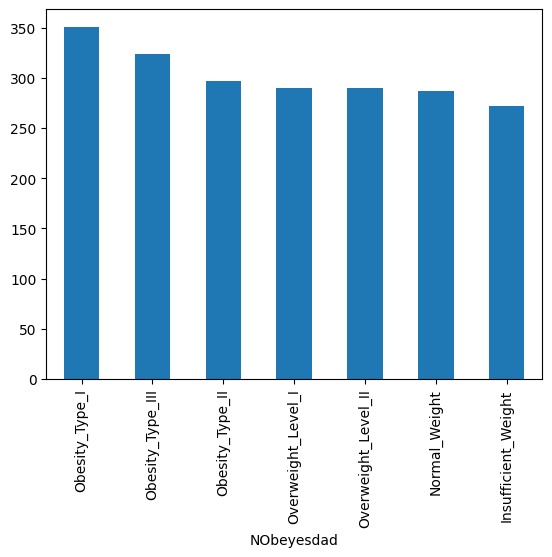

In [9]:
# balanced dataset μετά από SMOTE
df.NObeyesdad.value_counts().plot.bar() 

## Κατανομές Χαρακτηριστικών 

C:\Users\kosta\AppData\Local\Temp\ipykernel_21396\736712113.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(labels, rotation=45)


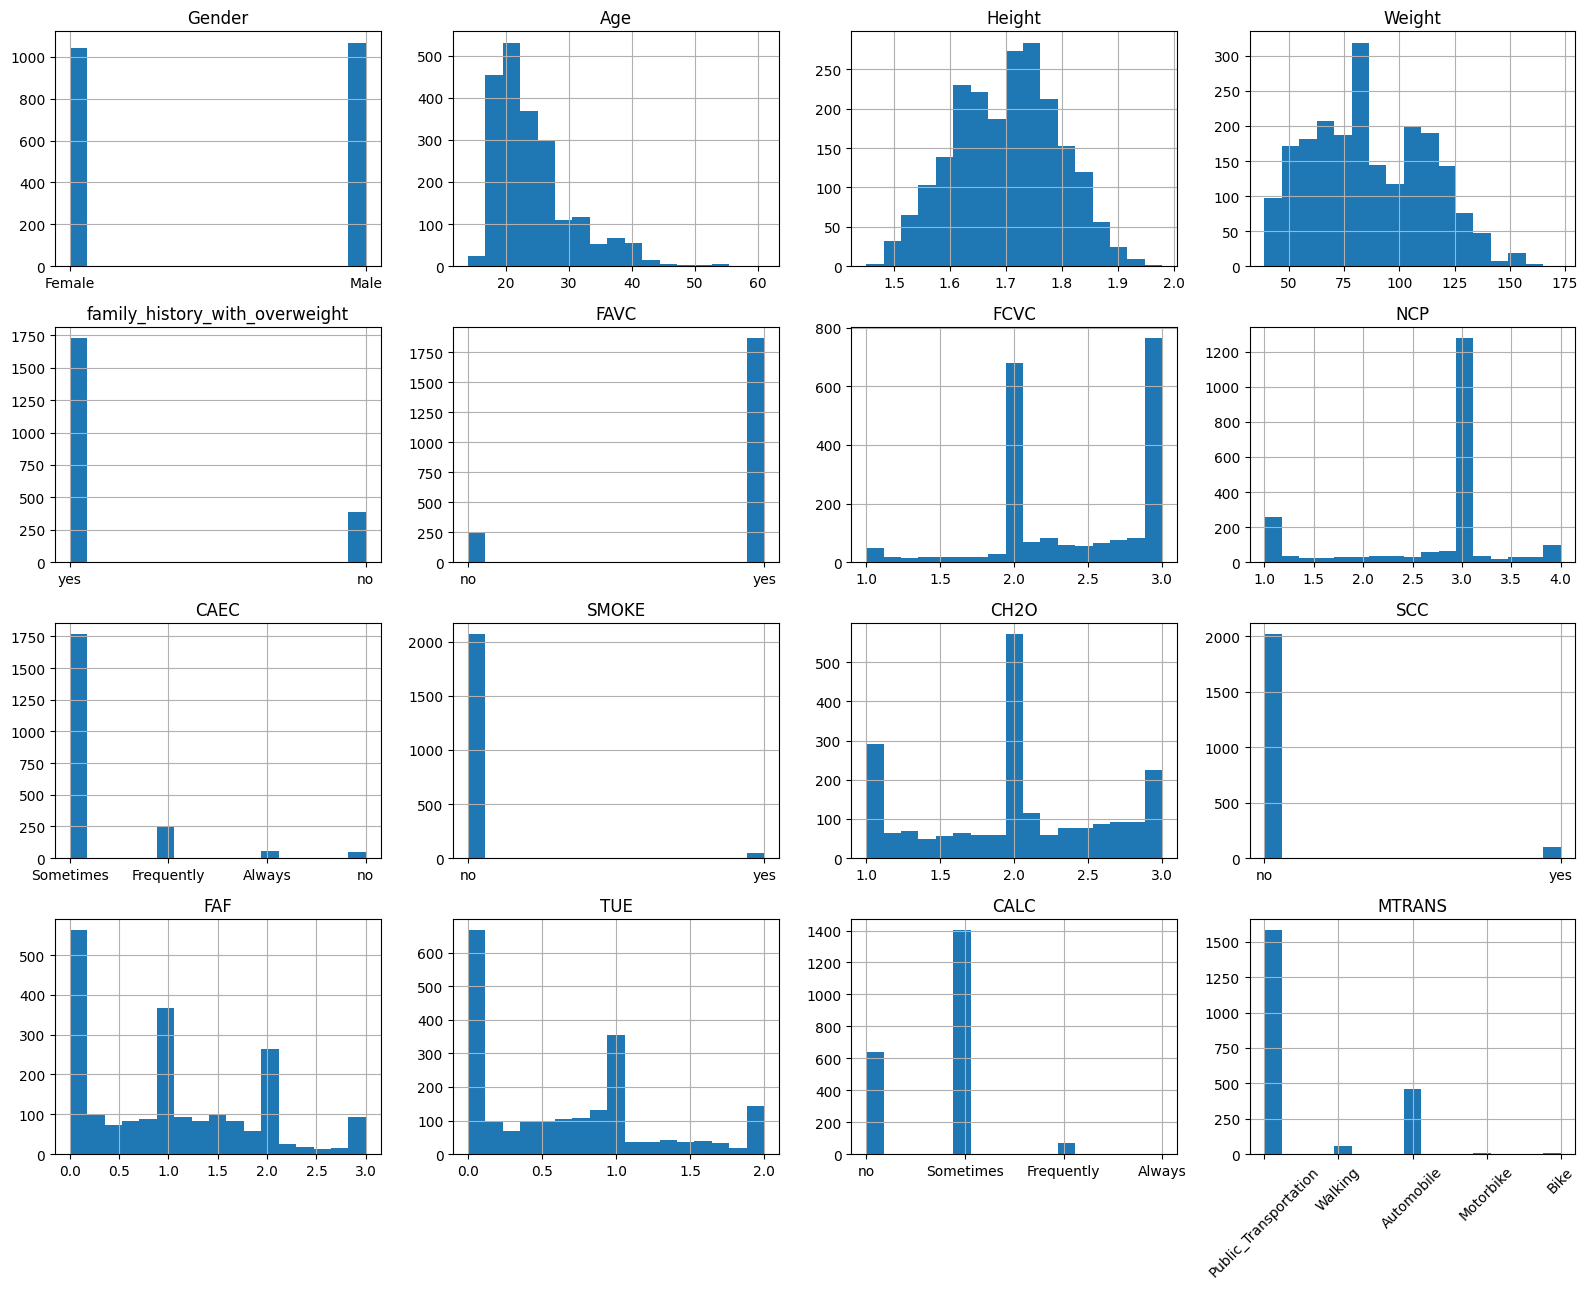

In [10]:
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(16, 13)) # 4 x 4 για τις κατανομές των 16 χαρακτηριστικών
axes = axes.flatten()  # flatten για ευκολότερο indexing

# Plot histograms
for i, col in enumerate(df.columns):
    if i != len(df.columns)-1: # η κατανομή του χαρακτηριστικού στόχου παρουσιάστηκε παραπάνω
        df[col].hist(ax=axes[i], bins=17)  # bins για τις συνεχείς μεταβλητές `Weight`, `Height`, `Age`
        axes[i].set_title(col)
        if i == len(df.columns)-2: # αφορά το χαρακτηριστικό `MTRANS`, rotation ώστε να είναι ευανάγνωστα
            labels = [tranportation for tranportation in df.MTRANS.unique()]
            axes[i].set_xticklabels(labels, rotation=45)

plt.tight_layout()
plt.show()

### Παρατηρήσεις Σχετικά με τα Χαρακτηριστικά του Συνόλου Δεδομένων
- **Τα χαρακτηριστικά** `FCVC`, `NCP`, `CH2O`, `FAF`, `TUE` τα οποία θα έπρεπε να λαμβάνουν μόνο διακριτές τιμές, εμφανίζουν ένα συνεχές εύρος.  
  - Αυτό παρατηρείται τόσο από τον τύπο των δεδομένων (`float` αντί για `object` ή `int`) όσο και από τα αντίστοιχα ιστογράμματα.
  - Η εμφάνιση αυτών των ενδιάμεσων τιμών οφείλεται στην παραγωγή συνθετικών δεδομένων με τη χρήση της τεχνικής SMOTE
- **Τα χαρακτηριστικά** `Smoke`, `SCC`, `CAEC`, `CALC`, `MTRANS` εμφανίζουν σπάνιες κατηγορίες, δηλαδή κατηγορίες που εμφανίζονται σε ένα πολύ μικρό υποσύνολο των παρατηρήσεων (σε αυτό το σημείο και το χαρακτηριστικό `NCP`).
- **Τα χαρακτηριστικά** `Weight` και `Age` φαίνεται να αποκλίνουν από την κανονική κατανομή, το δεύτερο εκ των οποίων παρουσιάζει ασυμμετρία (right-skewness), ενώ το χαρακτηριστικό `Height` ομοιάζει περισσότερο σε κανονική κατανομή, όπως φαίνεται και στα ακόλουθα boxplots.

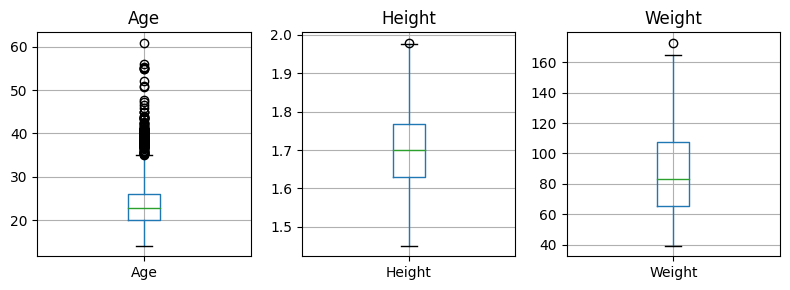

In [11]:
rows, cols = 1, 3

fig, axes = plt.subplots(rows, cols, figsize=(8, 3))  
axes = axes.flatten()
continuous = ["Age", "Height", "Weight"]

for i, col in enumerate(continuous):
    df.boxplot(column = col, ax=axes[i])  
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Μετατροπές των τιμών 

### Μετατροπή χαρακτηριστικών `FCVC`, `NCP`, `CH2O`, `FAF`, `TUE`, float σε integer

- Η μέθοδος SMOTE δημιουργεί νέα δεδομένα για την κατηγορία που βρίσκεται σε έλλειψη. Για κάθε σημείο αυτής της κατηγορίας, επιλέγει έναν ή περισσότερους κοντινότερους γείτονες και παράγει ένα νέο σημείο σε μια απόσταση a⋅dist, όπου dist είναι η απόσταση από τον κοντινότερο γείτονα και a μια υπερπαράμετρος με τιμές $0<a<1$. Συγκεκριμένα:
    - Όταν $a=0$, το νέο σημείο ταυτίζεται με το αρχικό.
    - Όταν $a=1$, το νέο σημείο συμπίπτει με τον γείτονα.
- Για παράδειγμα, αν η σπάνια κατηγορία είναι η `obesity III`, η μέθοδος SMOTE μπορεί να επιλέξει ένα δεδομένο με χαρακτηριστικό `FAF` = 1 και ως κοντινότερο γείτονά του (στον 16-διάστατο χώρο των χαρακτηριστικών) ένα δεδομένο με `FAF` = 0. Το νέο συνθετικό δεδομένο που θα παραχθεί θα έχει για το χαρακτηριστικό `FAF` μια ενδιάμεση δεκαδική τιμή μεταξύ 0 και 1, ανάλογα με την τιμή της υπερπαραμέτρου a.
- Συνεπώς, υπάρχουν δύο προσεγγίσεις:
    - Η πρώτη είναι να **στρογγυλοποιηθούν** οι τιμές στον πλησιέστερο ακέραιο, διασφαλίζοντας ότι τα δεδομένα παραμένουν στις προκαθορισμένες κατηγορίες.
    - Η δεύτερη, η οποία μπορεί να εφαρμοστεί μόνο σε διατεταγμένες κατηγορικές μεταβλητές (ordinal), είναι οι τιμές **να αφαιθούν ως έχουν**, επιτρέποντας στα tree based μοντέλα να "ομαδοποιήσουν" τις κατηγορίες μέσω των κατάλληλων split.
- **Η πρώτη προσέγγιση** διασφαλίζει τη συνέπεια με τα πραγματικά δεδομένα, καθώς νέα δείγματα θα ανήκουν πάντα σε μία από τις προκαθορισμένες κατηγορίες και όχι σε ενδιάμεσες τιμές οπότε τα χαρακτηριστικά `FCVC`, `NCP`, `CH2O`, `FAF`, `TUE` θα στρογγυλοποιηθούν και θα αντιμετωπιστούν ως **ordinal categorical**

In [12]:
# Η κατηγορίες που θα στρογγυλοποιηθούν

smote_rebuild = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

df[smote_rebuild] = df[smote_rebuild].map(round)

In [13]:
# έχουν πλέον ακέραιες τιμές

df[smote_rebuild].dtypes

FCVC    int64
NCP     int64
CH2O    int64
FAF     int64
TUE     int64
dtype: object

In [14]:
# Η κατηγορία 2 του χαρακτηριστικού `NCP` δεν είναι πλέον σπάνιο, αποτελεί το 8.33% των παρατηρήσεων

for col in smote_rebuild:
    print(df[col].value_counts(normalize=True), '\n')

FCVC
2    0.479867
3    0.471814
1    0.048318
Name: proportion, dtype: float64 

NCP
3    0.696352
1    0.149692
2    0.083373
4    0.070583
Name: proportion, dtype: float64 

CH2O
2    0.525817
3    0.244434
1    0.229749
Name: proportion, dtype: float64 

FAF
1    0.367598
0    0.341071
2    0.234960
3    0.056371
Name: proportion, dtype: float64 

TUE
0    0.450971
1    0.433444
2    0.115585
Name: proportion, dtype: float64 



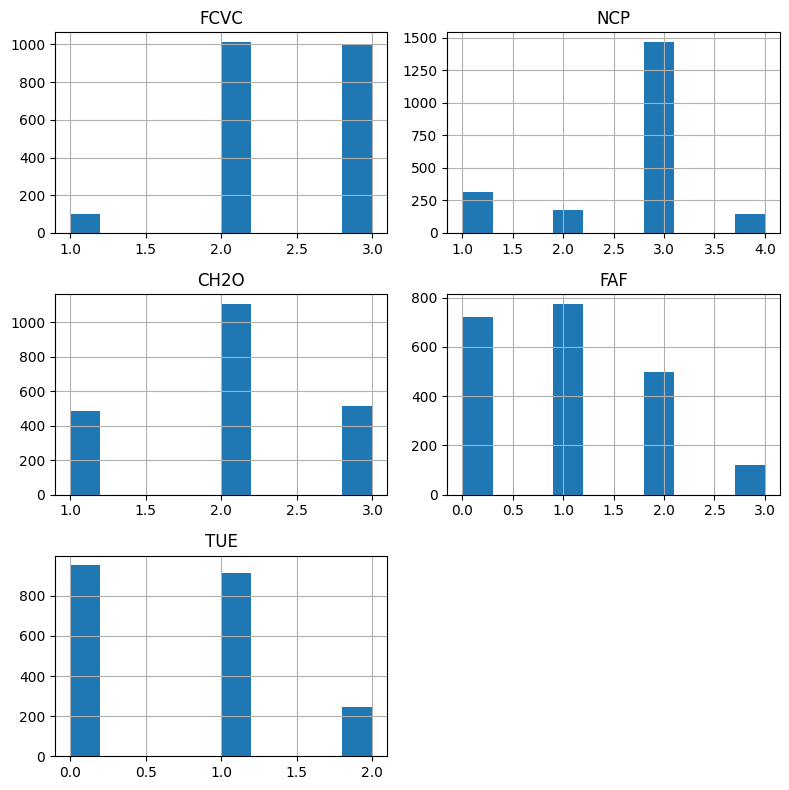

In [15]:
df[smote_rebuild].hist(figsize=(8, 8)) 

plt.tight_layout()

plt.show()

### Mετατροπή των κατηγορικών αλφαριθμητικών μεταβλητών σε αριθμητικές τιμές

- Τα χαρακτηριστικά `Gender`, `family_history_with_overweight`, `FAVC`, `SMOKE`, `SCC`, καθώς είναι δυαδικά (binary) θα γίνουν one-hot encoding με drop του ενός από τα δύο καθώς εμπεριέχουν την ίδια πληροφορία (Redundancy).
- Τα χαρακτηριστικά `CAEC` και `CALC`, θα μετατραπούν σε ordinal encoding καθώς η κατηγορίες τους διαθέτουν την πληροφορία μίας σειράς (no < Sometimes < Frequently < Always).
- Το χαρακτηριστικό `MTRANS` (nominal χαρακτηριστικό), θα κωδικοποιηθεί με one hot encoding. 
- Στα επόμενα notebooks θα πραγματοποιείται και κανονικοποιήση των συνεχών μεταβλητών. Η κανονικοποίηση δεν επηρεάζει την αποτελεσματικότητα ή την σύγκλιση των tree based μοντέλων. Θα εφαρμοστεί όμως καθώς βοηθάει στη ευκολότερη σύγκλιση του ελαχίστου όταν χρησιμοποιούνται **γραμμικά μοντέλα** τα οποία χρησιμοποιούνται σε μερικές μεθόδους feature selection (2.2 notebook) καθώς και σε συνδυασμό με τον AdaBoost classifier (3.0 notebook).

In [16]:
# Δημιουργία λίστας `categorical` με τα ονοματα των columns των κατηγορικών χαρακτηριστικών
# Εκτός από αυτές υπάρχουν και οι προηγούμενες 5 κατηγορίες (ordinal categories)
# Οι οποίες είναι integer οπότε θα μείνουν εκτός της λίστας

categorical = [col for col in df.columns if df[col].dtype == 'O' and col != 'NObeyesdad']

In [17]:
# αλφαριθμητικές μεταβλητ΄ές

for col in categorical:
    print(f"{col}:\t {df[col].unique()}")

Gender:	 ['Female' 'Male']
family_history_with_overweight:	 ['yes' 'no']
FAVC:	 ['no' 'yes']
CAEC:	 ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE:	 ['no' 'yes']
SCC:	 ['no' 'yes']
CALC:	 ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS:	 ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']


In [18]:
# Έλεγχος για σπάνιες κατηγορίες (quasi constant)
# `Smoke` 98% ίδιες τιμές
# `CALC`: Always -> 0.0474% των παρατηρήσεων
# `MTRANS`: Motorbike ->  0.52% και Bike -> 0.33%

for col in categorical:
    print(df[col].value_counts(normalize=True), '\n')

Gender
Male      0.505921
Female    0.494079
Name: proportion, dtype: float64 

family_history_with_overweight
yes    0.817622
no     0.182378
Name: proportion, dtype: float64 

FAVC
yes    0.883941
no     0.116059
Name: proportion, dtype: float64 

CAEC
Sometimes     0.836097
Frequently    0.114638
Always        0.025107
no            0.024159
Name: proportion, dtype: float64 

SMOKE
no     0.979157
yes    0.020843
Name: proportion, dtype: float64 

SCC
no     0.954524
yes    0.045476
Name: proportion, dtype: float64 

CALC
Sometimes     0.663667
no            0.302700
Frequently    0.033160
Always        0.000474
Name: proportion, dtype: float64 

MTRANS
Public_Transportation    0.748460
Automobile               0.216485
Walking                  0.026528
Motorbike                0.005211
Bike                     0.003316
Name: proportion, dtype: float64 



In [19]:
# χαρακτηριστικά που ΄διαθέτουν μόνο δύο πιθανές τιμές, binary

binary = [column for column in categorical if df[column].nunique() == 2]

In [20]:
binary

['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

In [21]:
# one hot encoding

df = pd.get_dummies(df, columns=binary, drop_first=True, dtype='int32')

In [22]:
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes
0,21.0,1.62,64.0,2,3,Sometimes,2,0,1,no,Public_Transportation,Normal_Weight,0,1,0,0,0
1,21.0,1.52,56.0,3,3,Sometimes,3,3,0,Sometimes,Public_Transportation,Normal_Weight,0,1,0,1,1
2,23.0,1.80,77.0,2,3,Sometimes,2,2,1,Frequently,Public_Transportation,Normal_Weight,1,1,0,0,0
3,27.0,1.80,87.0,3,3,Sometimes,2,2,0,Frequently,Walking,Overweight_Level_I,1,0,0,0,0
4,22.0,1.78,89.8,2,1,Sometimes,2,0,0,Sometimes,Public_Transportation,Overweight_Level_II,1,0,0,0,0


- Η κατηγορία Always στο χαρακτηριστικό `CALC` είναι σπάνια (0.0474%, 1 δεδομένο από τα 2111), οπότε θα ομαδοποιηθεί με την κατηγορία Frequently η οποία είναι εννοιολογικά πλησιέστερα στην Always.

In [23]:
# 1 δεδομένο με df["CALC"]=="Always"

df.loc[df["CALC"]=="Always"]

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes
26,21.0,1.7,65.0,2,1,Frequently,2,1,2,Always,Walking,Normal_Weight,1,1,1,0,0


In [24]:
# Μετατροπή του "Always" σε "Frequently"

df.loc[df["CALC"]=="Always", "CALC"] = "Frequently"

In [25]:
# Μετατροπή των αλφαριθμητικών τιμών σε αριθμητικές, ως συχνότητα `calc` (κατανάλωσης αλκόολ)

calc_map = {"no": 0,
           "Sometimes": 1,
           "Frequently": 2}

df["CALC"] = df["CALC"].map(calc_map)

In [26]:
# Μετατροπή των αλφαριθμητικών τιμών σε αριθμητικές, ως συχνότητα `caec` (φαγητό ενδιάμεσα στα γεύματα)

caec_map = {"no": 0,
           "Sometimes": 1,
           "Frequently": 2,
           "Always": 3}

df["CAEC"] = df["CAEC"].map(caec_map)

In [27]:
# Σπ΄άνιες κατηγορίες Bike και Motorbike

df.MTRANS.value_counts()

MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

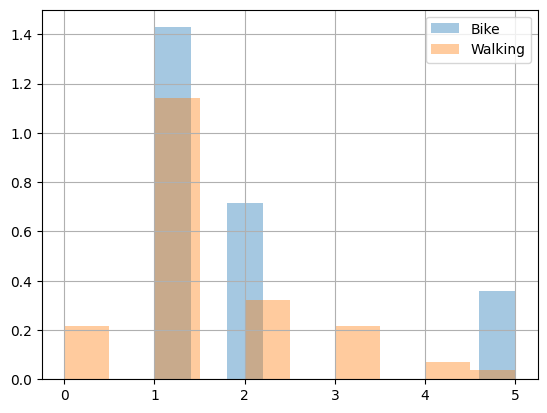

In [28]:
# mapping σε integer ως προς τον βαθμό παχυσαρκίας για ευκολότερη κατανόηση των κατανομ΄΄ών

map_dict = {"Insufficient_Weight": 0, 
            "Normal_Weight":1, 
            'Overweight_Level_I':2, 
            'Overweight_Level_II':3, 
            'Obesity_Type_I':4, 
            'Obesity_Type_II':5, 
            'Obesity_Type_III':6} 

df['NObeyesdad'] = df['NObeyesdad'].map(map_dict)

a = 0.4
df[df['MTRANS'] == 'Bike']['NObeyesdad'].hist(alpha=a, density=True, label='Bike')
df[df['MTRANS'] == 'Walking']['NObeyesdad'].hist(alpha=a, density=True, label='Walking')
plt.legend()

- Οι δύο κατανομές διαφέρουν ελάχιστα. Αυτή η διαφορά μπορεί να ευθύνεται σε άλλου παράγοντες (χαρακτηριστικά) και όχι σε αυτά τα δύο.
- Τα δύο αυτά χαρακτηριστικά θα ομαδικοποιηθούν λόγω της ομοιότητας τους σε φυσική δραστηριότητα σε σχέση με τα υπόλοιπα.
- Η κατανομή του πληθυσμού μπορεί να διαφέρει κατά πολύ από αυτή του δείγματός μας, καθώς το δείγμα είναι πολύ μικρό.

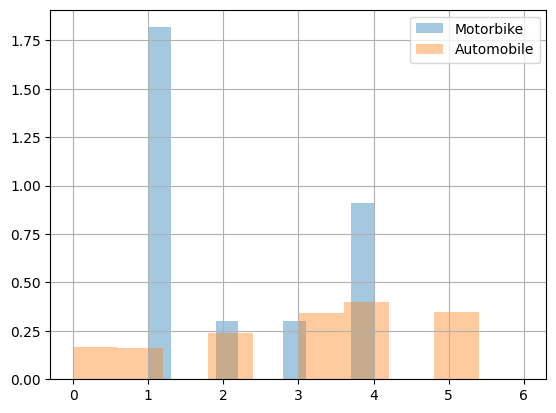

In [29]:
# Η κατανομή διαφέρει ως ενα βαθμό, όμως τα δύο δείγματα είναι πολύ μικρά

df[df['MTRANS'] == 'Motorbike']['NObeyesdad'].hist(alpha=a, density=True, label='Motorbike')
df[df['MTRANS'] == 'Automobile']['NObeyesdad'].hist(alpha=a, density=True, label='Automobile')
plt.legend()

In [30]:
# ομαδοποίηση των δύο ζεγαρι΄ών

df.loc[df["MTRANS"]=="Bike", "MTRANS"] = 'Walking'
df.loc[df["MTRANS"]=="Motorbike", "MTRANS"] = 'Automobile'

In [31]:
# one hot encoding των υπόλοιπων

df = pd.get_dummies(df, columns=["MTRANS"], drop_first=True, dtype='int32')

In [32]:
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2,3,1,2,0,1,0,1,0,1,0,0,0,1,0
1,21.0,1.52,56.0,3,3,1,3,3,0,1,1,0,1,0,1,1,1,0
2,23.0,1.80,77.0,2,3,1,2,2,1,2,1,1,1,0,0,0,1,0
3,27.0,1.80,87.0,3,3,1,2,2,0,2,2,1,0,0,0,0,0,1
4,22.0,1.78,89.8,2,1,1,2,0,0,1,3,1,0,0,0,0,1,0


In [33]:
numeric = ['Age', 'Height', 'Weight']
categorical = [col for col in df.columns if col not in numeric]

In [34]:
# count: συνολικός αριθμός τιμών (2111 παντού λόγω non missing values)
# unique: αριθμός κατηγοριών
# top: η πιο πολυπληθέστερη κατηγορία
# freq: αριθμός παρατηρήσεων της κατηγορίας top

df[categorical].astype("O").describe(include='O')

,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Public_Transportation,MTRANS_Walking
count,2111,2111,2111,2111,2111,2111,2111,2111,2111,2111,2111,2111,2111,2111,2111
unique,3,4,4,3,4,3,3,7,2,2,2,2,2,2,2
top,2,3,1,2,1,0,1,4,1,1,1,0,0,1,0
freq,1013,1470,1765,1110,776,952,1401,351,1068,1726,1866,2067,2015,1580,2048


## - Κατασκευή του τελικού preprocessing pipeline με σκοπό τη μετατροπή των δεδομένων. 
## - Τα προεπεξεργασμένα δεδομένα αποθηκεύονται σε νέο αρχείο, το οποίο θα χρησιμοποιηθεί στα επόμενα notebook 

In [35]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [36]:
binary = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
smote_rebuild = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
numeric = ['Age', 'Height', 'Weight']

In [37]:
preprocess_pipeline = Pipeline([
    # Κανονικοποίηση
    ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=numeric)),
    
    # mapping του `MTRANS`
    ('mtrans_map', MtransMapper(variables='MTRANS')),
    
    # στρογγυλοποίση
    ('rounding', RoundTransformer(variables=smote_rebuild)),
    
    # Ordinal Encoding
    ('ordinal_CALC', OrdinalEncoder(variables = 'CALC')), 
    ('ordinal_CAEC', OrdinalEncoder(variables = 'CAEC')), 
    ('ordinal_NObeyesdad', OrdinalEncoder(variables = 'NObeyesdad')), 
    
    # binary encoding
    ('binary', OneHotEncoder(variables=binary, drop_last=True)),
    
    # one hot encoding
    ('one_hot', OneHotEncoder(variables='MTRANS', drop_last=True)),
])

In [38]:
preprocess_pipeline.fit(df)
df_trans = preprocess_pipeline.transform(df)

In [39]:
# μετακίνηση της στήλης στόχου 'NObeyesdad' στο τέλος 

cols = [col for col in df_trans.columns if col != 'NObeyesdad']
cols.append('NObeyesdad')
df_trans = df_trans[cols]

In [40]:
df_trans

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,Gender_Female,family_history_with_overweight_yes,FAVC_no,SMOKE_no,SCC_no,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,-0.522124,-0.875589,-0.862558,2.0,3.0,1,2.0,0.0,1.0,0,1,1,1,1,1,1,0,1
1,-0.522124,-1.947599,-1.168077,3.0,3.0,1,3.0,3.0,0.0,1,1,1,1,0,0,1,0,1
2,-0.206889,1.054029,-0.366090,2.0,3.0,1,2.0,2.0,1.0,2,0,1,1,1,1,1,0,1
3,0.423582,1.054029,0.015808,3.0,3.0,1,2.0,2.0,0.0,2,0,0,1,1,1,0,1,2
4,-0.364507,0.839627,0.122740,2.0,1.0,1,2.0,0.0,0.0,1,0,0,1,1,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,-0.525774,0.097045,1.711763,3.0,3.0,1,2.0,2.0,1.0,1,1,1,0,1,1,1,0,6
2107,-0.367195,0.502844,1.800914,3.0,3.0,1,2.0,1.0,1.0,1,1,1,0,1,1,1,0,6
2108,-0.281909,0.541672,1.798868,3.0,3.0,1,2.0,1.0,1.0,1,1,1,0,1,1,1,0,6
2109,0.007776,0.404927,1.785780,3.0,3.0,1,3.0,1.0,1.0,1,1,1,0,1,1,1,0,6


## Τα preprocessed δεδομένα υπάρχουν ήδη αποθηκευμένα στον φάκελο.

In [41]:
# df_trans.to_csv('data_preprocessed.csv', index=False)